# Explore Generalized Cross-Validation

*This notebook visualizes the effect of the rotation used by Generalized Cross-Validation.*

## Import dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import peak_engines
import scipy
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

## Load the Boston Housing dataset

In [2]:
X, y = load_boston(return_X_y=True)
X = StandardScaler().fit_transform(X)

## Compute leave-one-out error ratios

In [3]:
def compute_ridge_regression_prediction(X, y, alpha, X_test):
    z = np.dot(np.conj(X.T), y)
    R = scipy.linalg.qr(X, mode='r')[0]
    E = np.dot(np.conj(R.T), R) + np.diag(alpha)
    L =  np.linalg.cholesky(E)
    beta = scipy.linalg.solve_triangular(L, z, lower=True)
    beta = scipy.linalg.solve_triangular(np.conj(L.T), beta, lower=False)
    return np.dot(X_test, beta)

In [4]:
def compute_loo_error_ratios(X, y, alpha):
    errors = y - compute_ridge_regression_prediction(X, y, alpha, X)
    result = []
    index = 0
    for train_indexes, test_indexes in LeaveOneOut().split(X):
        X_train, X_test = X[train_indexes], X[test_indexes]
        y_train, y_test = y[train_indexes], y[test_indexes]
        y_pred = compute_ridge_regression_prediction(X_train, y_train, alpha, X_test)
        loo_error = y_test[0] - y_pred[0]
        result.append(np.abs(loo_error) / np.abs(errors[index]))
        index += 1
    return np.array(result)

In [5]:
def compute_loocv_error_ratios(X, y, alpha, fit_intercept=True):
    n, k = X.shape
    if fit_intercept:
        alpha = np.array([alpha]*k + [0])
        X = np.hstack((X, np.ones((n, 1))))
        k +=1
    else:
        alpha = np.ones(k)*alpha
    return compute_loo_error_ratios(X, y, alpha)

## Compute the leave-one-out error ratios after rotatation
First transforms the dataset using the Generalized Cross-Validation rotation, then computes the error ratios.

For details on the rotation, read [What Form of Cross-Validation Should You Use](https://towardsdatascience.com/what-form-of-cross-validation-should-you-use-76aaecc45c75).

In [6]:
def compute_gcv_error_ratios(X, y, alpha, fit_intercept=True):
    n, k = X.shape
    if fit_intercept:
        alpha = np.array([alpha]*k + [0])
        X = np.hstack((X, np.ones((n, 1))))
        k +=1
    else:
        alpha = np.ones(k)*alpha
    U, S, Vt = np.linalg.svd(X)
    S = np.vstack((np.diag(S), np.zeros((n-k, k))))
    W = np.array([[np.exp(2j*np.pi*i*j/n) / np.sqrt(n) for j in range(n)] for i in range(n)])
    X_prime = np.dot(W, np.dot(S, Vt))
    y_prime = np.dot(W, np.dot(U.T, y))
    return compute_loo_error_ratios(X_prime, y_prime, alpha)

## Visualize the error ratios

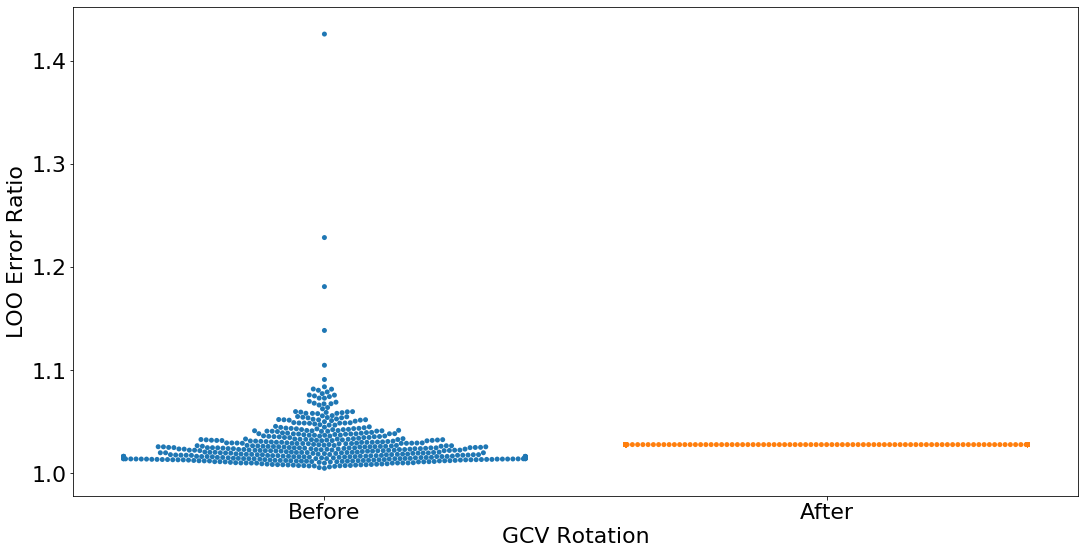

In [7]:
plt.figure(figsize=(18,9))
alpha = 5.5
loocv_error_ratios = compute_loocv_error_ratios(X, y, alpha)
gcv_error_ratios = compute_gcv_error_ratios(X, y, alpha)
error_ratios = list(loocv_error_ratios) + list(gcv_error_ratios)
cv = ["Before"]*len(y) + ["After"]*len(y)
df = pd.DataFrame({"LOO Error Ratio": error_ratios, "GCV Rotation": cv})
sns.swarmplot(y="LOO Error Ratio", x="GCV Rotation", data=df)